# Predicting the rate of COVID-19 transmission

In this notebook, we will build a machine learning model that will use hospitalization and infection data to predict the rate of COVID-19 transmission in the United States. If we can accurately predict future transmissions, we can help doctors and policymakers determine how to should allocate resources and craft interventions. In this notebook, we'll:


1.   Explore our data
2.   Use linear regression to predict future cases
3.   Use neural networks to predict future cases
4.   (Optional): Interactively explore underfitting and overfitting
5.   (Advanced Challenge): Adapt our model to predict many days into the future

![COVID map](https://upload.wikimedia.org/wikipedia/commons/f/f1/COVID-19_Prevalence_in_the_United_States_by_county.svg)



In [1]:
#@title Run this to prepare your data! { display-mode: "form" }

# source of data: https://www.kaggle.com/roche-data-science-coalition/uncover?

# Load the data!
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import math
from math import sqrt
import random
import scipy
from scipy.interpolate import make_interp_spline

# see all columns and rows
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 40)
# set seed
random.seed(1)

import gdown 
gdown.download('https://drive.google.com/uc?id=1oK8AlCRFp4isBJQv-AZnC_zr-ZvrOOxd','covid-statistics-by-us-states-daily-updates.csv',True);

raw_data = pd.read_csv('covid-statistics-by-us-states-daily-updates.csv')

# turn date into datetime object
raw_data["date"] = pd.to_datetime(raw_data["date"], format="%Y-%m-%d")

raw_data.set_index("date", inplace = True, drop = False)

state_df_list = []
for name, df in raw_data.groupby("state"):
  tomorrow_data = df[['date','positiveincrease']]
  tomorrow_data.columns = ['tomorrow_date', 'tomorrow_new_pos']
  tomorrow_data['today_date'] = tomorrow_data.tomorrow_date - timedelta(days=1)
  tomorrow_data.set_index("today_date", inplace = True)
  state_df = df.join(tomorrow_data, how = 'inner')
  state_df_list.append(state_df)

data = pd.concat(state_df_list)
data.drop(['date','tomorrow_date'],axis=1,inplace=True)
data = data[~data.totaltestresultsincrease.isna()]
data = data[~data.total.isna()]
data = data[~data.positive.isna()]
data.negative = data.total - data.positive

data.sort_index(inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 1. Data exploration

### Filtering our data

Let's take a look at an example row from our data:

In [3]:
data.head(1)

,state,positive,negative,pending,hospitalizedcurrently,hospitalizedcumulative,inicucurrently,inicucumulative,onventilatorcurrently,onventilatorcumulative,recovered,hash,datechecked,death,hospitalized,total,totaltestresults,posneg,fips,deathincrease,hospitalizedincrease,negativeincrease,positiveincrease,totaltestresultsincrease,tomorrow_new_pos
2020-01-23,WA,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,faa0d0b985f479eac50082e417dc84f9e645db8f,2020-01-23 21:00:00,NaN,NaN,1.0,1.0,1.0,53,0.0,0.0,0.0,0.0,0.0,0.0


We only care about data that will help us predict rates of COVID-19. Right now, our data contains many unnecessary columns of information -- let's filter out unnecessary data.

We'll use each day's data to try to predict the number of positive test results the next day.

We want to include only the following columns: 

1. **"Date"**: the date for this row. This is already done for you - it's the index of the dataset - so you don't need to get this column)
2. **"State"**: the state that we're collecting COVID information about.
3. **"Positive"**: the total number of people who've tested positive for COVID up to today.
4. **"Negative"**:  the total number of people who've tested negative for COVID up to today.
5. **"Total"**: The total number of tests done up to today
6. **"Hospitalizedincrease"**: number of additional people who were hospitalized for conditions relating to COVID-19, compared to yesterday
7. **"Negativeincrease"**: Number of new negative tests today
8. **"Positiveincrease"**: Number of new positive tests today
9. **"Totaltestresultsincrease"**: Total number of new tests today
10. **"tomorrow_new_pos"**: Number of new positive results the next day. This is what we'll try to predict!

**NOTE**: The date column is automatically included in your data, so you don't need to worry about that column.


In [10]:
#Use a line like this to choose the columns - replace "YOUR COLUMNS!"
#data = data[["YOUR COLUMNS"]] 

#YOUR CODE HERE to chose columns:
data = data[["state", "positive", "negative", "total", "hospitalizedincrease", "negativeincrease", "positiveincrease", "totaltestresultsincrease", "tomorrow_new_pos"]] 


### Visualizing our data

Before we create our model, we need to understand our dataset and how we can use the data to answer our question. Let's take a look at our dataset!

In [11]:
data.head(15) #Try changing the number of rows

,state,positive,negative,total,hospitalizedincrease,negativeincrease,positiveincrease,totaltestresultsincrease,tomorrow_new_pos
2020-01-23,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-27,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-28,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-29,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-30,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-31,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-02-01,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Try printing the number of **rows** and the number of **columns** in the dataset.

(Hint: the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html) might help `shape` your thinking.)

In [14]:
#YOUR CODE HERE to identify the number of rows and columns:
num_rows = data.shape[0]
num_columns = data.shape[1]

#END YOUR CODE

print (num_rows, "rows")
print (num_columns, "columns")

2915 rows
9 columns


### Analyzing our data

Our overall goal is to create a model that can predict the number of new positive COVID-19 cases the next day. A good first step is to see how many positive COVID-19 cases each state has been having so far.


You've chosen to see the data for the state of AK


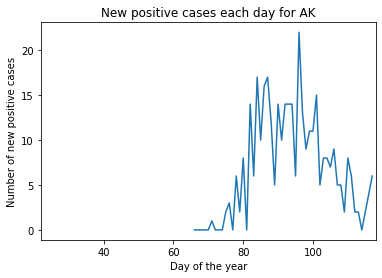

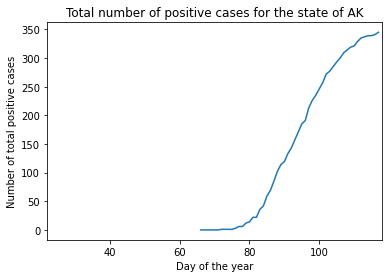

In [24]:
#@title ### Type in a state's two-letter abbreviation (e.g. CA for California) to see a graph of that state's positive COVID-19 cases over time. Try comparing the data for a few states!

# get state
state = "AK" #@param {type:"string"}

# get uppercase version
state=state.upper()

# get states
states = set(data["state"])

# check to see if entry is in the state
if state not in states:
    raise ValueError("Abbreviation isn't a state. Please try again")
print(f"You've chosen to see the data for the state of {state}")


# check out graphs of positive cases, by week
new_data=data[data["state"] == state]
new_data.index = (new_data.index - datetime(2020, 1, 1)).days

plt.plot(new_data.index, new_data.tomorrow_new_pos)
plt.title(f"New positive cases each day for {state}")
plt.ylabel("Number of new positive cases")
plt.xlabel("Day of the year")
plt.xlim(22, 118)
plt.show()

plt.plot(new_data.index, new_data.positive)
plt.title(f"Total number of positive cases for the state of {state}")
plt.ylabel("Number of total positive cases")
plt.xlabel("Day of the year")
plt.xlim(22, 118)
plt.show()

### Questions to consider

What trends do you notice in COVID cases in different states? Where are there the most cases? Where do cases grow most quickly?

The data describes cases up until April. Can you predict the trends in May?


## 2. Linear Regression

Now that we've done some exploratory analysis, we can start modeling. It's good practice to start with simpler models such as linear regression, see what patterns we can pick up on from creating these models, and then move on to more complex models such as neural networks.


### Review: What is linear regression?

**Linear regression** models the relationship between an **independent variable** `x` and a **dependent variable** `y` as a line:

$$y= mx + b$$


**(Optional)** Let's explore linear regression through a [demo!](http://setosa.io/ev/ordinary-least-squares-regression/)

### Fitting a linear regression

Now that we have some idea of what a linear regression is, let's create one! We'll need to:

1. Prepare our data and perform a train-test split
2. Create and train our linear regression model
3. Make predictions using our model
4. Evaluate our model

**Why do we need each step?**

First, we need to separate `X_raw` (our input: all the columns with today's data) from `y_raw` (our output: the number of positives tomorrow.) Create the data frames below using `data`:

In [26]:
#YOUR CODE HERE to create data frames X_raw and y_raw
X_raw = data.drop(["tomorrow_new_pos"], axis=1)
y_raw = data[["tomorrow_new_pos"]]

Now, let's handle a few data formatting issues: we'll convert the State column to one-hot-encoded columns and add a new day_of_year column. Check out the code if you're curious!

In [27]:
#@title Run this to format data

# let's one-hot-encode our states
one_hot_columns = pd.get_dummies(X_raw.state, prefix="state")

# append one_hot_columns
X = pd.concat([X_raw, one_hot_columns], axis=1)
X.drop('state',axis=1,inplace=True)

X["day_of_year"] = (X.index - datetime(2020, 1, 1)).days

X.reset_index(inplace = True, drop=True)
y = y_raw.reset_index(drop = True)

X.head(5)

,positive,negative,total,hospitalizedincrease,negativeincrease,positiveincrease,totaltestresultsincrease,state_AK,state_AL,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,day_of_year
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,23
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,24
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,25
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,26


#### 1. Perform a train-test split

Before we can create our model, we have to split our data into training and test data. **Why?**

Often, we split randomly. But today, we'll split by time: the first few months of our data will be the training data and the last few weeks will be testing data. **Question: Why split by time instead of randomly?**

It's to make sure that our model has never learned any information about the testing data. If we split randomly, we could have days in the testing data which are the "tomorrow" of a day in the training data!



Let's use an 80%/20% train-test split. Calculate the number of rows to use in training data:

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Does the `shape` of each frame look right?

In [31]:
#YOUR CODE HERE to check out what each frame looks like
print(f"X train is: {X_train.shape}")
print(f"y train is: {y_train.shape}")
print(f"X test is: {X_test.shape}")
print(f"y test is: {y_test.shape}")

X_train.head()

X train is: (2332, 64)
y train is: (2332, 1)
X test is: (583, 64)
y test is: (583, 1)


,positive,negative,total,hospitalizedincrease,negativeincrease,positiveincrease,totaltestresultsincrease,state_AK,state_AL,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,day_of_year
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,23
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,24
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,25
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,26


#### 2. Create and train our linear regression model

Now, let's create our linear regression model! We'll use the linear regression model from Scikit-learn.


In [32]:
# Run this cell to set up the linear regression model
linear = linear_model.LinearRegression()

Next, let's train our linear regression model on our data.

In [33]:
# YOUR CODE HERE to train our model! What are the inputs?
#Example: linear.fit(FILL ME IN)
linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### 3. Make predictions using our model

Now, let's make some predictions on the test set!



In [34]:
# YOUR CODE HERE to test our model! What are the inputs?
#Example: y_pred = linear.predict(FILL ME IN)
y_pred = linear.predict(X_test)

Remember how we're testing our model: we're giving the model true information about each day in the test set, and asking it to predict the number of positives the next day. How does it do?

You've chosen to see the data for the state of MS


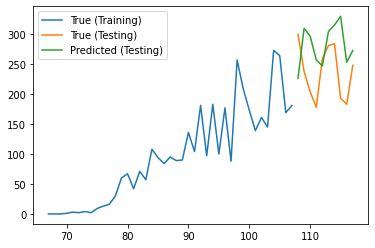

In [35]:
#@title ### Type in a state to check out our model's predictions

# get state
state = "ms" #@param {type:"string"}

def plot_true_and_pred(state, y_pred):
  # get uppercase version
  state=state.upper()

  # check to see if entry is in the state
  if state not in set(data["state"]):
      raise ValueError("Abbreviation isn't a state. Please try again")
  print(f"You've chosen to see the data for the state of {state}")

  y_pred_series = pd.Series(y_pred.squeeze(), index = y_test.index)

  X_train_state = X_train[X_train["state_"+state] == 1]
  X_test_state = X_test[X_test["state_"+state] == 1]

  early_true = y_train.loc[X_train_state.index]
  late_true = y_test.loc[X_test_state.index]
  late_pred = y_pred_series.loc[X_test_state.index]

  plt.plot(X_train_state.day_of_year, early_true)
  plt.plot(X_test_state.day_of_year, late_true)
  plt.plot(X_test_state.day_of_year, late_pred)
  plt.legend(["True (Training)", "True (Testing)", "Predicted (Testing)"])
  plt.show()

plot_true_and_pred(state, y_pred)


**Question**: How well is our model doing in different states? Does it tend to overestimate or underestimate? Do you notice other patterns?

Overall, our model seems to do well at predicting the number of cases *the next day*!

**Question:** How could we adapt our model to predict the number of cases one *week* or one *month* in the future, instead of one day ? Do you expect it would do well?

#### 4. Optional: Evaluate our model

When we're comparing models, it's not enough to eyeball a graph: we want to **measure** how well our predictions match reality. Let's use a common metric called **Mean Squared Error**. 

For the curious: to calculate MSE, we measure out error (how far off we were) in each prediction, square each error, and take the average to find the Mean Squared Error across all rows.


In [ ]:
from sklearn.metrics import mean_squared_error #Use this function!

#YOUR CODE HERE to calculate mse_linear
mse_linear = None
#END CODE

print ("MSE for linear model:", mse_linear)

## 3. Neural Networks

We're doing pretty well with simple linear regression methods - but can we do even better?

Let's see if we can improve our MSE with a more complex model: Neural Networks.

![Neural Network](https://upload.wikimedia.org/wikipedia/commons/e/e4/Artificial_neural_network.svg)



Recall that a neural network consists of layers of interconnected "neurons", which learn to identify patterns in the input to make a prediction. For many tasks, like computer vision or speech recognition, neural networks far exceed other types of machine learning algorithms!


#### **(Optional)** Tensorflow Playground Activity

Open [this](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.62283&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&learningRate_hide=true&batchSize_hide=true&stepButton_hide=true&activation_hide=true) to experiment with Neural Networks!

### Fitting a neural network

We will use `MLPRegressor`, which is a simple neural network model from Scikit-learn. We will experiment with the **number of neurons** and the **number of hidden layers** to improve the performance of our model!

**Example 1:**

If we want to create a neural network with 1 hidden layer and 4 neurons, we would say:

`nnet = MLPRegressor(hidden_layer_sizes=(4)) `

**Example 2:**

If we want to create a neural network with 2 hidden layers and 3 neurons in each layer:

`nnet = MLPRegressor(hidden_layer_sizes=(3, 3)) `

### Exercise 1: 

Create a neural network with 4 hidden layers and 10 neurons in each layer. The code will be similar to your linear regression code above!

Note: you might notice different results if you run this cell multiple times! Why?





In [37]:
from sklearn.neural_network import MLPRegressor

# Creates the neural net
nnet = MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10), #YOUR CODE HERE to set the hidden layer sizes
                    activation="relu",
                    max_iter= 100000)

#YOUR CODE HERE to train the neural net (1 line):
nnet.fit(X_train, y_train)

#YOUR CODE HERE to make predictions on the test set (1 line):
nnet_preds = nnet.predict(X_test) 

#YOUR CODE HERE to calculate and print out the MSE (1-2 lines):
mse_nnet = mean_squared_error(y_true= y_test, y_pred= nnet_preds)
print(f"MSE: {mse_nnet}")

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE: 617577.0937055331


As before, we can graph the reality and predictions. Try changing the state!

You've chosen to see the data for the state of WA


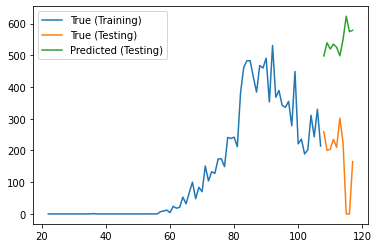

In [38]:
plot_true_and_pred("WA",nnet_preds)

**Question:** Based on the graphs and MSE, did the neural network do better or worse than linear regression? Why might this be?

### Exercise 2:
Using a `for` loop, try experimenting with changing the **number of neurons** and the **number of hidden layers** in your neural net. What's the best MSE you can achieve?

In [ ]:
for hidden_layer_sizes in [(1),(10,10)]: #YOUR CODE HERE to complete the list
  None #YOUR CODE HERE to train and evaluate our model

###Discussion Questions

1. In what cases (if any) would linear regression perform better than a neural network?

2. In what cases (if any) would a neural network perform better than linear regression?

###(Advanced) Exercise 3: Hyperparameter Tuning
You'll recall that in [TensorFlow Playground](playground.tensorflow.org/), we had many **hyperparameters** to play around with, including:

*   Learning rate
*   Activation function
*   Regularization 
*   Regularization rate
*   Number of layers 
*   Number of neurons in each layer

As you experiment with TensorFlow Playground, what patterns do you notice? Which hyperparameters make a big difference?

You can also change these options (and more) in your MLPRegressor code! Check out your options in [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) and adapt your previous code.

Experiment using your intuition from TensorFlow Playground: **How much improvement can you make in the MSE?**

In particular, try tuning `learning_rate_init`. The learning rate controls how quickly the model adjusts its weights after seeing each example. Some learning rates to try: 0.001, 0.01, 0.05 and 0.1. 

In [ ]:
#YOUR CODE HERE for hyperparameter exploration with for loops!

## 4. Optional: Bias and Variance


Because of its complexity, your neural network might have suffered from **overfitting**: "memorizing" the training data rather than learning the underlying patterns. 

In general, in supervised machine learning we face a trade-off between two kinds of error:


*   **Bias**, where your model isn't flexible enough to learn the true shape of the data and **underfits**, vs.
*   **Variance**, where your model is *too* flexible and **overfits** the shape of the data.

Check out the following diagrams for examples:



![image](https://cdn-images-1.medium.com/max/1600/1*9hPX9pAO3jqLrzt0IE3JzA.png)

![image](https://qph.fs.quoracdn.net/main-qimg-c7c08113b7806da89fc0cd7928d1ee50)


Let's play around with the idea of bias vs. variance in the code chunk below. First, let's generate some points that we want to plot:

In [ ]:
#@title Run this cell to create random X and y values
X_rand = np.linspace(0, 15, 50) # 50 evenly spaced numbers in interval [0, 15]
y_rand = (5 * X_rand) + (1.75 * np.random.normal(scale=10, size=len(X_rand))) # y = X + (2 * Gaussian noise (~N(0, 10)))
plt.scatter(X_rand, y_rand)
plt.show()

**How can we look at the plot above and predict the y-value of a given point X?**

### One approach is to start with a simple line:

Let's start by trying **Linear Regression**. Choose a slope $m$ and y-intercept $b$ for our linear equation:

$$y= mx + b$$


In [ ]:
#@title Let's define a line and see how well it fits our data:

slope=1#@param {type:"integer"}
y_intercept=0#@param {type:"integer"}

# get predicted y-values based off line
predicted_y_rand= (slope * X_rand) + y_intercept

# plot points, superimpose red line for predictions
plt.scatter(X_rand, y_rand)
plt.plot(X_rand, predicted_y_rand, color="red")
plt.show()


**Can you find the combination of slope and y_intercept that best fits our set of points?**

Either experiment with different slope and y-intercept values in the code chunk above, or write your own code below.

In [ ]:
#YOUR CODE HERE to get the best slope and intercept

### Fitting other functions

But we don't have to fit a straight line! Instead, we could fit a curved function using **polynomials**. Potentially, these more complicated shapes could fit our data better.

Here's one example of a **polynomial** you might have seen:

$$y=ax^2 + bx + c$$

Here, $a$ and $b$ are coefficients (like slopes) while $c$ is the y-intercept.

By using higher powers of $x$, we can make more complex polynomials with more coefficients, like:

$$y=ax^3 + bx^2 + cx + d$$ 

$$y=ax^4 + bx^3 + cx^2 + dx + e$$ 




Let's try fitting a fourth-degree polynomial to our data: $y=ax^4 + bx^3 + cx^2 + dx + e$

In [ ]:
#@title Fill in values for the coefficients below and let's see how well our curve fits the points

a=0.007#@param {type:"number"}
b=-0.25#@param {type:"number"}
c=2.5#@param {type:"number"}
d=-3#@param {type:"number"}
e=2#@param {type:"number"}

# get predicted y-values based off line
predicted_y_rand= (a*np.power(X_rand, 4)) + (b*np.power(X_rand, 3)) + (c*np.power(X_rand, 2)) + (d*np.power(X_rand, 1)) + e

# plot points, superimpose red line for predictions
plt.scatter(X_rand, y_rand)
plt.plot(X_rand, predicted_y_rand, color="red")
plt.ylim(0, 120)
plt.show()


**Experiment with a, b, c, d, e** to find the best fit you can! Then run this code chunk to see the best solution:

In [ ]:
#@title After experimenting, run this chunk to find the best fit

# use polyfit(), with 4th degree fitting
rand_polyfit = np.polyfit(X_rand, y_rand, deg = 4)

# get coefs of polynomial fit
a=rand_polyfit[0]
b=rand_polyfit[1]
c=rand_polyfit[2]
d=rand_polyfit[3]
e=rand_polyfit[4]

# get predicted y-values based off line
predicted_y_rand_polynomial = (a*np.power(X_rand, 4)) + (b*np.power(X_rand, 3)) + (c*np.power(X_rand, 2)) + (d*np.power(X_rand, 1)) + e

# plot points, superimpose red line for predictions
plt.scatter(X_rand, y_rand)
plt.plot(X_rand, predicted_y_rand_polynomial, color="red")
plt.ylim(0, 120)
plt.show()



It seems like our polynomial line does better than our straight line at fitting our data! If we make our line more curvy, can we get an even better fit?

In [ ]:
#@title An **extreme** version of a polynomial fit is just connecting all the points!

# plot points, superimpose red line for predictions
plt.scatter(X_rand, y_rand)
plt.plot(X_rand, y_rand, color="red")
plt.ylim(0, 120)
plt.show()



We now have a function that fits our data **perfectly**! Sounds good, right?

But - how well would this function do at predicting the `y` for a **new** `x`?

Why might we want to use a **more** or **less** curved line?

Let's see how well our three functions do at predicting a new point.

In [ ]:
#@title Define a new (x,y) coordinate for our new data point, which will be graphed in purple.
x=14#@param {type:"number"}
y=60#@param {type:"number"}

# let's get what our equations would predict:
new_y_line = (slope * x) + y_intercept
new_y_polynomial = (a * np.power(x, 4)) + (b * np.power(x, 3)) + (c * np.power(x, 2)) + (d * np.power(x, 1)) + e

# let's plot our points

# using the linear regression
plt.scatter(X_rand, y_rand)
plt.ylim(0, 120)
plt.scatter(x, y, color="purple", s=75)
plt.plot(X_rand, predicted_y_rand_linear, color="red")
plt.title("Fitting using the straight line")
plt.show()

# using the polynomial fit
plt.scatter(X_rand, y_rand)
plt.ylim(0, 120)
plt.scatter(x, y, color="purple", s=75)
plt.plot(X_rand, predicted_y_rand_polynomial, color="green")
plt.title("Fitting using the 4th-degree polynomial")
plt.show()

# using the extreme polynomial fit
plt.scatter(X_rand, y_rand)
plt.ylim(0, 120)
plt.scatter(x, y, color="purple", s=75)
plt.plot(X_rand, y_rand, color="red", dashes=[6,2])
plt.title("Fitting using the extreme polynomial")
plt.show()




After trying several points, **which of the three graphs does the best** at predicting possible future points? **Where's the balance** between too "rigid" and too "curvy"?

###Questions:

1. Which graphs have high **bias**, and which have high **variance**?

2. Comparing a linear regression and a neural network, which is more likely to have high **bias** or **variance**? Why?

3. For COVID-19 predictions, would you prioritize choosing a model with **low bias** or **low variance**? Why?


#5. Advanced Challenge: Modeling the Future

Going back to our COVID models - we've made pretty good models for predicting the number of positives one day in the future. But for policy decisions, it would be useful to predict further ahead! **How could we use our model to predict COVID positives many days ahead?**

One approach is to feed our predictions back into the model: using real data for one day, generate a prediction for the next day. Then assume that prediction is accurate, feed it back into the model, and get a prediction for the day after that. Continue into the future! **How well do you expect this to work?**



Let's try it out! **First, go back and retrain your models, using only `state` and `positiveincrease` as input features**.  (For the other variables, we wouldn't know how to set their future values). You can use a linear or neural network model.

Now, pick a state to experiment with! This code will pick out the testing and training data for your state.

In [ ]:
state = 'tx' #Pick a state!
state=state.upper()

X_train_state = X_train[X_train["state_"+state] == 1]
X_test_state = X_test[X_test["state_"+state] == 1]

print ("Training and testing shapes:", X_train_state.shape, X_test_state.shape)

current_day = X_train_state.iloc[-1:].copy()

current_day

In `current_day`, you see your starting point: the real data for your state on the last day of the training data.

Now, build out `pred_list`: your list of predictions for the coming days, which we'll graph against the testing data! For each day, you'll need to make a prediction for the model, save your prediction in `pred_list`, and update `current_day` with the new information. Which columns will you need to change? 

In [ ]:
pred_list = [] 

#At the end of your code, pred_list should be the same length as 
#X_test_state and contain your predictions for the future!

#YOUR CODE HERE:

In [ ]:
#@title Now, run this code to graph your predictions against the true data in your state!

early_true = y_train.loc[X_train_state.index]
late_true = y_test.loc[X_test_state.index]
late_pred = pred_list

plt.plot(X_train_state.day_of_year, early_true)
plt.plot(X_test_state.day_of_year, late_true)
plt.plot(X_test_state.day_of_year, late_pred)
plt.title(f"New positive cases each day for {state}")
plt.legend(["True (Training)", "True (Testing)", "Predicted"])
plt.show() 

**How'd you do?** Can you think of some reasons to explain your results?

Could you imagine other techniques for predicting far into the future?

## Conclusion

Great work! In this notebook, you learned about using machine learning to predict COVID-19 rates! After completing this notebook, you have a better idea of how to explore your data, when and how to use linear regression, when and how to use neural networks, and how to interpret your results. You'll take these skills into some of the more advanced topics later on in this course!